<a id="top"></a> 
# Modeling Place Fields with Point Process Generalized Linear Models

## Introduction
In chapter 8, we used visualization methods and simple interspike interval models to describe the spiking properties of a retinal neuron that was maintained at constant light and environmental conditions. In other words, we examined a neuron that was firing on its own, without any explicit driving stimuli. In contrast, many neuroscience experiments involve stimulating or perturbing a neural system and recording changes in spiking activity of a set of neurons in response to that stimulus. The stimulation may be a simple signal applied directly to the neural system, such as a current pulse injected into a neuron. Or it may be a more complex or abstract stimulus that is sensed in the peripheral nervous system and influences neural activity elsewhere, such as the presentation of a movie composed of a natural scene to an awake animal, inducing activity patterns in primary visual cortex and downstream areas.

This stimulus-response paradigm relates to the important concept of *neural coding*: that statistical features of spiking activity contain information about the stimuli, behaviors, or other biological signals that influence the activity. From a data analysis perspective, we are interested in modeling the relation between these signals and the observed spiking activity. We can do so through a statistical spike train model. Here we explore a useful class of models based on the statistical theory of point processes. We define the models in terms of a Poisson rate function, which defines the instantaneous likelihood of observing a spike at any point in time as a function of a set of covariates. In particular, we use a class of point process models that can be fitted by maximum likelihood and whose estimators have multiple optimal properties. These are called generalized linear models (GLMs). We provide some basic statistical ideas to develop intuition about these types of models, but readers can explore the rich theory underlying this approach via the references mentioned in this chapter.

### Case study data
A collaborator has contacted us to discuss a new experiment he has performed. As part of this experiment, he has implanted a small bundle of electrodes in a rat’s hippocampus and trained the rat to perform a simple spatial task: to run back and forth along a linear maze. During this task, our collaborator believes he has recorded the spiking activity from a place cell, a cell whose activity is position-specific. He has asked us to help characterize these spike train data and support (or refute) the notion that the observed cell is a place cell. He has agreed to provide us with the observed spike train data and the position of the rat as a function of time, recorded during a few minutes of the experiment.

### Goals
Our goal is to characterize the properties of the observed cell as the rat runs back and forth in the linear maze. Spiking activity in these cells is known to relate to other variables, such as the speed and head direction of the rat. Here, we focus on modeling the relation between the rat’s movement trajectory and the observed spiking activity. In doing so, we select a model through an iterative process of model fitting, evaluation, and refinement.

### Tools
In this chapter, we develop a series of generalized linear models. We implement procedures to fit, refine, and compare this series of models. We demonstrate the process of implement- ing and fitting a Poisson regression model in Python, procedures to evaluate model goodness-of-fit and compare models, and methods to construct confidence intervals for model parameters.

## Data Analysis

### Visual Inspection


In [1]:
# Prepare the modules and plot settings
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel, ylabel, plot, show, title
from matplotlib import rcParams
import numpy as np
%matplotlib inline
rcParams['figure.figsize'] = (9,5)

First we load the file Ch9-spikes-1.mat. The variable `X` indicates the rat’s position (in centimeters) at each moment in time (variable `t`, in seconds). The variable `spiketimes` indicates the times (in seconds) at which spikes occur in the data.

We begin with visual inspection of the data. Let’s first plot the rat’s movement trajectory as a function of time:

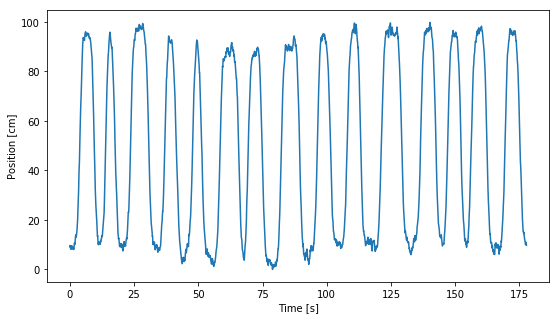

In [2]:
data = sio.loadmat('Ch9-spikes-1.mat')  # Load the EEG data
t = data['t'][:,0] # Extract the t variable
X = data['X'] # Extract the X variable
plot(t, X)
plt.xlabel('Time [s]')
plt.ylabel('Position [cm]')
show()

The plot shows that the rat runs back and forth consistently, making about 15 passes during the approximately 3 minute recording. We also observe that the rat moves fairly quickly during each back and forth pass but spends a large amount of time at both ends of the track (near position 0 cm or 100 cm) before turning around and continuing.

Next, we would like to plot the spiking activity in relation to the rat’s movement trajectory. However, we cannot simply plot the vector `X` against the vector `spiketimes`; these vectors have different lengths. The length of `X` is the same as the length of `t`, the total number of 1 ms time bins in the recording (177,761 time bins). The length of spiketimes is the total number of spikes to occur during the duration of the recording: 220 spikes. Therefore, the first step to visualizing the place-specific spiking activity is to use `spiketimes` to create a new vector, with the same size as X, that indicates whether a spike was fired at each time bin. Let’s call this vector `spiketrain` and have it contain 1 for each time bin where a spike occurs and 0 for each time bin that lacks a spike.

<div class="alert alert-block alert-info">
**Q:** How would you construct the vector `spiketrain`? Can you think of multiple ways to construct the same vector?
<br><br>

**A:** We could use a for-loop to step through each time bin and decide whether a spike occurred. A more efficient approach is to realize that this computation can be performed as a histogram, and use the numpy function histogram. There are many other ways to compute this same vector.
</div>

In [3]:
spiketimes = data['spiketimes']
n_bins = len(t)
# Histogram spikes into bins centered at times t.:
spiketrain= np.histogram(spiketimes, bins = n_bins, range = (t[0], t[-1]))[0] 

Now we can plot the position and spike train together. In Python,

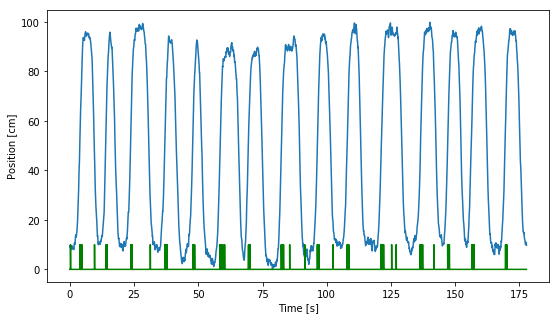

In [4]:
plot(t,X) # Plot the position
plot(t,10*spiketrain,'g') # Plot the spikes
plt.xlabel('Time [s]')
plt.ylabel('Position [cm]')
show()

<div class="alert alert-block alert-info">
**Q**: Is there a better way to visualize the spiking activity and position?<br><br>
**A**: Keeping the variable `spiketrain`, let’s compute a new variable, `spikeindex`, using the numpy command `where`:<br>
`spikeindex=np.where(spiketrain!=0)[0]  #Deterime index of each spike.` <br><br>
The vector `spikeindex` represents the vector indices at which spikes occur. We can use this to index any of the variables whose size matches the number of time bins in the recording. So, another visualization we can now employ is to plot the times and positions of the spikes overlaid on the full movement trajectory. In Python:<br>
`plot(t, X)                             #Plot the position.
plot(t[spikeindex],X[spikeindex],'r.') #Plot spikes @ positions.
plt.xlabel('Time [sec]')               #Label the axes.
plt.ylabel('Position [cm]')`<br><br>
Note that by using the `'r.'` term in the plot function, we indicate the times and positions of the spikes as red dots.
</div>

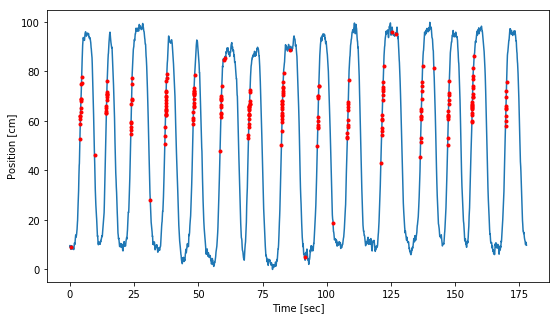

In [5]:
spikeindex = np.where(spiketrain!=0)[0]     # Plot the position.
plot(t, X)                               # Plot the position.
plot(t[spikeindex], X[spikeindex], 'r.')
plt.xlabel('Time [sec]')                 # Label the axes.
plt.ylabel('Position [cm]')
show()

From the above figure, it is clear that the preponderance of the spiking is occurring whenever the rat is running up the track, in the direction where `X` is increasing, at values of `X` ranging from about 50 cm to about 80 cm. We do not see the same spiking activity in this region when the rat is running back down the track, in the direction where `X` is decreasing. A few spikes occur at other locations, but these appear sparse compared to the place-specific firing in this region.

Another way to visualize this place field structure is to construct an occupancy normalized histogram of the spiking activity. To do so, we define a set of position bins spanning the full 100 cm track, count the number of spikes that occur in each location bin, and divide by the occupancy, the total amount of time spent at each location bin. Dividing by the occupancy is important. Otherwise differences in the way the stimulus is presented can bias the characterization of the stimulus response relation. For example, if the rat spent much more time in the 50–80 cm region, we might expect more firing in that region even if the firing does not depend on place at all. Based on our previous visualization, we know that this is not the case for these data, but it is important to keep in mind how the statistics of a stimulus signal might influence the statistics of an output signal.

Let’s compute the occupancy normalized histogram in Python:

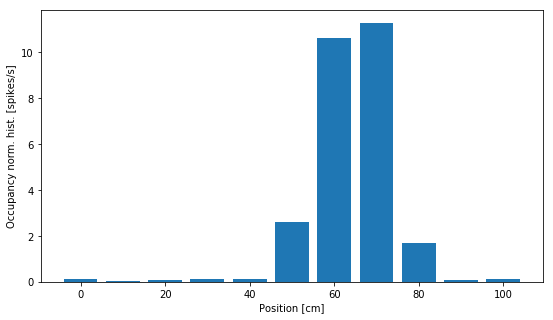

In [6]:
bin_edges = np.arange(-5, 106, 10)                         # Define spatial bins.
spikehist = np.histogram(X[spikeindex], bin_edges)[0]      # Histogram positions @ spikes.
occupancy=np.histogram(X, bin_edges)[0]*0.001              # Convert occupancy to seconds.
plt.bar(np.linspace(0, 100, 11), spikehist/occupancy, width=8)  # Plot results as bars.
plt.xlabel('Position [cm]')                                     # Label the axes.
plt.ylabel('Occupancy norm. hist. [spikes/s]')
show()

In the third line of this code, we multiply the occupancy by 0.001 to put the occupancy in units of seconds and the occupancy normalized histogram in units of spikes per second. From the occupancy normalized histogram in the figure, we see that the firing rate is highest around the 60–70 cm position and falls off rapidly as the rat moves away from that location. This corroborates the results from our previous visualizations. However, there is one feature of the spiking activity that we observed previously for which we are not accounting in this visualization. Here we are relating spiking purely to position without regard for the direction of the rat’s movement.

<div class="alert alert-block alert-info">
**Q**: How might we construct a visualization that accounts for spiking as a function of both position and direction?
<br><br>
**A**: One option is to construct separate occupancy normalized histograms for movement in each direction. To do so, we would need to determine for each time step whether it represents a movement period where the position is increasing or decreasing. How would you do this? (We do so later when constructing place field models.)
</div>

### Fitting a Point Process Model (Poisson GLM)

Any statistical model that describes data occurring at localized points in time, like spike times, is called a temporal point process model. In chapter 8, we constructed a point process model that described the probability distribution of waiting times between spikes for a neuron with no explicit driving stimulus. Here, we would similarly like to construct a statistical model, but in this case the model should characterize how the distribution of the data depends on the covariates of interest: the rat’s position and movement direction.

<div class="alert alert-block alert-info">
**Q:** Do the notions of point process model, Poisson model, and rate parameter seem familiar? <br><br>
**A:** If not, consider reviewing the case study in chapter 8.
</div>

One approach we used to model the spiking data in chapter 8 was a Poisson model, in which we used a rate parameter, $\lambda$, to define the expected rate of spiking in any time interval. We then computed the value of $\lambda$ that maximized the likelihood of observing the recorded spiking activity. For the data of interest here, we extend this concept by defining a rate that varies in time as a function of some set of covariates. These covariates are any variables whose influence on the spiking activity we wish to explore. Our visualizations suggest that useful covariates for our model include the rat’s position and its direction of motion.

Let’s define some terms. Let $x(t)$ represent the rat’s position at time $t$, and let $d(t)$ represent the direction of motion; we set $d(t) = 0$ when $x(t)$ is decreasing or the rat is stopped, and $d(t) = 1$ when $x(t)$ is increasing. Since these position and direction signals change as a function of time, so does the firing rate. We write $\lambda(t) = g(x(t), d(t))$, where $\lambda(t)$ is called the *Poisson rate function*, and $g(·, ·)$ is a function that we need to define the model.

What function should we use for $g(·, ·)$? We want something that captures the relation between the covariates and the spiking, and is easy to interpret. The process of finding a model or set of models that are most consistent with the data is called model identification or model selection. Typically, this is an iterative process where we propose a class of models, find the particular model in that class that best fits the data, assess the quality of that model, and decide whether to refine the model further or to draw conclusions from the model fit. In practice, it is a good idea to begin with descriptive statistics and visualizations of the relation between the covariates and spiking data to select a class of point process models. For the spike train data of interest here, our visualizations suggest a model where the dependence of spiking on position has a mound shape (as in the occupancy normalized histogram) and which incorporates direction. We start with an overly simple model for pedagogical purposes.

The following is a very basic model inspired by simple linear regression: 
<p title="Model 1">$$ \lambda(t) = \beta_0 + \beta_1x(t). $$</p>

The idea of linear regression is to express a response variable at time $t$ in terms of predictor variables, or covariates. Here, $\beta_0$ and $\beta_1$ are unknown parameters used to characterize a linear dependence between the response variable $\lambda(t)$ and covariate $x(t)$. $\beta_0$ represents the expected firing rate at $x(t) = 0$, and $\beta_1$ represents the change in firing rate for each unit of increase in position. This initial model does not include any dependence on the rat’s movement direction (i.e., there’s no $d(t)$ term).

The form of the model looks like a standard linear regression, which is comforting because methods exist in Python to solve these types of problems. However, the observed data are spike events; in discrete time, the data are spike counts. A standard linear regression assumes that the distribution of the data, given the covariates, is normal. Spike counts can take on only non-negative integer values, so their distribution cannot be normal. When the number of spike counts in each time bin is very large, it is possible that the distribution of the data can be approximated by a normal distribution, and in this case, simple regression methods might work. But for the spiking data of interest here, we have very few spikes (0 or 1) in each 1 ms time bin, so a simple regression fit would not be correct.

Instead, we must fit a *Poisson regression model* to the data. If we let $N(t)$ be the number of spikes that are observed in the interval $(t, t +  \Delta t)$, then under the Poisson regression model, $N(t)$ has a Poisson distribution with a mean parameter equal to the response variable $\lambda(t)$ integrated over the interval $(t, t +\Delta t)$.

How do we fit the Poisson regression model? It turns out that Poisson regression models of a certain form can be fitted efficiently using the theory of generalized linear models. In Python, we can fit this model using the glmfit function. Before applying this function directly to the data, let’s get an overview of the function’s inputs and outputs. In Python, we consider the GLM model from the package `statsmodel`. We will construct a model using:

`GLM(Y, X_1, family(link)).`

The first input, `Y`, is a vector of the spike counts at each time step. In this case, `Y` is the vector `spiketrain` that we computed earlier. The second input, `X_1`, is a matrix of the covariates on which spiking depends. The size of this matrix is `n × p`, where `p` is the number of covariates in the model, and `n` is the number observations or time steps. Since our model is given by $\lambda(t) = \beta_0 + \beta_1x(t)$, we will prepend a column of ones to the data matrix `X`, so that we can fit the intercept $\beta_0$ to our data. Thus, `X_1` is an `n × 2` matrix, where `n` is the number of data points (177,761) representing the position of the rat along the track. The third input indicates the distribution of the spike count data in `Y`. For a Poisson regression model of spike count data, we use the Poisson family. In fact, for most neural spike count models fitted using GLM, even those that are not Poisson processes, we use the Poisson distribution. The family input is characterized by link function between the spiking rate and the covariates. Specifically, if we want to fit a model of the form $h(\lambda(t)) = \beta_0 + \beta_1x(t)$, then we would say that the function $h(·)$ is the link function. For model 1, this is simply the identity function. In what follows, we show a better way to select this link function.

The `params` attribute of the `fit` function is a vector of numbers representing the maximum likelihood estimates of the model parameters, which for this example we have labeled $\beta_0$ and $\beta_1$. We use the “hat” notation above a parameter to represent its estimate. The maximum likelihood estimate of $\beta_0$ is written $\hat{\beta_0}$, and the maximum likelihood estimate of $\beta_1$ is written $\hat{\beta_1}$.
Let’s now use this function to fit the parameters of model 1 to the observed location and spiking data. In Python,

In [7]:
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.families.links import identity

X1 = sm.tools.tools.add_constant(X) # Prepend a column of ones to our position data matrix
model1 = sm.GLM(spiketrain, X1, family=Poisson(identity)) # GLM model with Poisson family and identity link function
model1_results = model1.fit() # Fit model to our data
b1 = model1_results.params # Get the predicted coefficient vector

/usr/local/lib/python3.5/site-packages/statsmodels/genmod/generalized_linear_model.py:302: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


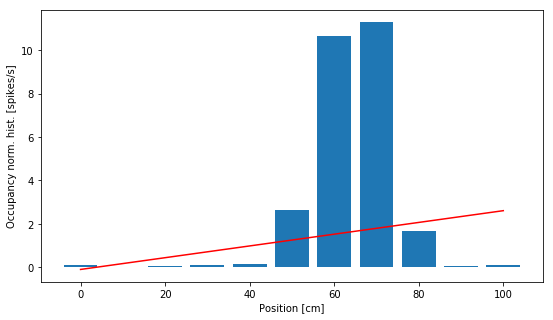

In [8]:
bins = np.linspace(0, 100, 11)
plt.bar(bins, spikehist/occupancy, width=8)    # Plot results as bars.
plot(bins,(b1[0]+b1[1]*bins)*1000,'r')         # Plot model.
plt.xlabel('Position [cm]')                    # Label the axes.
plt.ylabel('Occupancy norm. hist. [spikes/s]')
plt.show()

<div class="alert alert-block alert-info">
**lambda does not match**
**Q:** Upon executing this command in Python, what do you find? Do the results make sense?<br><br>

**A:** Initially, you may notice that Python outputs at the command line a warning that this model—particularly the identity link function— may be inappropriate. Let’s ignore this warning and attempt to interpret the resulting parameter estimates. The first of these values is the maximum likelihood estimate for $\beta_0$. If we believed this model was accurate, we could interpret this parameter as indicating that the expected firing rate at position x = 0 is λ = −0.103 × 10−3 spikes per millisecond, or about −0.1 spikes per second, and that as the rat moves in the positive direction, the firing rate increases by β1 = 0.0272 spikes per second for every centimeter the rat moves. This result should immediately raise some red flags. The fact that the firing rate is negative indicates that the model becomes uninterpretable for observed values of x. This suggests one major problem with model 1—the firing rate is negative—and motivates changes to the model link function.
To further visualize the quality of this model, we can compare the dependence it defines between position and spike rate to the occupancy normalized histogram we

</div>

### Refining the model

We conclude that our initial proposal, model 1, does not represent the data well. Therefore, let’s refine the model to account for the identified issues. First, let’s choose a link function that is more appropriate for point process modeling. We would like a function that ensures the rate function is non-negative and that is easy to fit. The theory of generalized linear modeling suggests one function in particular: the log link. We set the log of the firing rate to be a linear function of the covariates. If we maintain position as the sole covariate, this leads to a model of the form:
<p title="Model 2a"> $$\log \lambda(t) = \beta_0 + \beta_1 x(t), $$</p>
or equivalently,
<p title="Model 2b">$$\lambda = e^{\beta_0+\beta_1x(t)}.$$</p>

This link function is called the canonical link for Poisson data. It has a number of appealing
properties. As desired, it ensures that the rate function is positive.

<div class="alert alert-block alert-info">
**Q:** Consider the expression for λ(t) in (9.3). Why must λ(t) always be positive?
</div>

The choice of a log link also ensures that the likelihood of the data is concave with respect to the model parameters. This means that the likelihood only has one local maximum value, which is the maximum likelihood (ML) estimate. It can also be shown that in many cases, the parameter estimators will be asymptotically normal, which will allow us to construct confidence intervals and make significance statements about them [6].

To fit model 2 in Python, we use the same model as before but replace the the link function with log:

In [9]:
from statsmodels.genmod.families.links import log # Import log link function

model2 = sm.GLM(spiketrain, X1, family=Poisson(log)) # GLM model with Poisson family and log link function
model2_results = model2.fit() # Fit model to our data
b2 = model2_results.params # Get the predicted coefficient vector

In fact, if we omit the name of the link function in the glmfit routine, it will automatically use the canonical link for the selected distribution. Since the log link is canonical for Poisson data, we can simply run the commands:

In [10]:
model2 = sm.GLM(spiketrain, X1, family=Poisson()) # GLM model with Poisson family, omitting link function
model2_results = model2.fit() # Fit model to our data
b2 = model2_results.params # Get the predicted coefficient vector

<div class="alert alert-block alert-info">
**Q:**  Execute the fit function with the log link in Python. What do you find? <br><br>

**A:** This time, we find that Python does not issue a warning that the link function may be inappropriate. Inspection of the estimated parameter values reveals b2 = [-7.43888719  0.01294342]. These values are markedly different from the parameter values b found using model 1. The reason for this difference is that the form of the model has a major impact on the interpretation of the parameter values. In what follows, we discuss the interpretation of these parameter values in detail.
</div>

Let’s examine the model fit more closely. When x = 0, the firing rate under model 2 is

$$\begin{align}\lambda(t) &= \exp(\beta_0 + \beta_1 \times 0)\\
&= \exp(\beta_0)\\
&= 0.0006\text{ spikes/ms}\\
&= 0.6 \text{ spikes/s,}\end{align}$$

where we have used the value $\beta_0 = b2[0]$. If the rat moves from position x = 0 to x = 1, the firing rate becomes

$$\begin{align}\lambda(t) &= \exp(\beta_0 + \beta_1 × 1) \\
&= \exp(\beta_0 + \beta_1)\\
&= \exp(\beta_0)\exp(\beta_1)\\
&= 1.013 \exp(\beta_0),\end{align}$$

where we have used the value $\beta_1 = b2[1]$. That is, a 1 cm increase in position increases the firing rate 1.3%. Because of the link function, position now has a multiplicative rather than an additive effect on the firing rate. Instead of adding to the firing rate, each increase of position leads to a multiplicative modulation of the firing rate at about a 1% increase per cm. Let’s see how this model looks by comparing it to the occupancy normalized histogram of the data. In Python,

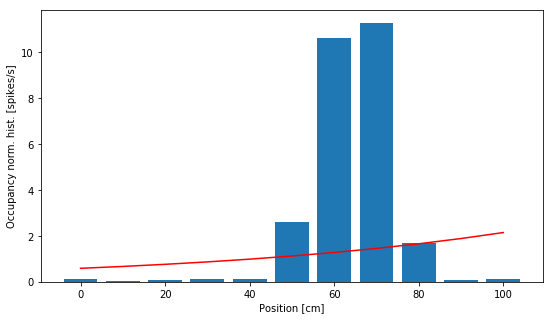

In [11]:
plt.bar(bins, spikehist/occupancy, width=8)    # Plot results as bars.
plot(bins,np.exp(b2[0]+b2[1]*bins)*1000,'r')   # Plot model.
plt.xlabel('Position [cm]')                    # Label the axes.
plt.ylabel('Occupancy norm. hist. [spikes/s]')
plt.show()

<div class="alert alert-block alert-info">
**Q:** Consider model 2 and the data (the figure above). How do the two compare? <br> <br>

**A:** Visual inspection suggests that we’ve solved one problem: the spike rate is no longer negative anywhere. However, the model fit still does not agree with the structure seen in the occupancy normalized histogram. We have improved the link function, but using only the position itself as a covariate leads to a rate that is an exponential function of the rat’s position.
</div>

There are many variables we might think to add to this model, but what variables could we add to better capture the dependence between firing rate and position, in particular? One thought might be to include nonlinear terms, such as the square of the position value. This gives us a third candidate model:

<p title="Model 3">$$\lambda(t) = \exp(\beta_0+\beta_1x(t)+\beta_2x(t)^2).$$</p>

Compared to model 2, we’ve now included an additional $x(t)^2$ term and unknown coefficient $\beta_2$.

<div class="alert alert-block alert-info">
**Q:** We said previously that we would use generalized linear models. Does the use of the nonlinear term $x(t)^2$ violate this?<br><br>

**A:** It might be better to think of linear in “generalized linear models” as requiring some function of the mean of the response variable to be a linear function of the coefficients (i.e., the $\beta$’s). The covariates can be linear or nonlinear functions of observed quantities (e.g., the position squared, the sine of the angle of head direction, etc.)
</div>

To fit model 3 in Python, we add another column to the matrix of covariates, the second argument of the GLM model.

In [12]:
#Fit Model 3 to the spike train data (omitting last input).

X2 = np.hstack([X1,X**2]) #Add column for x(t)^2
model3 = sm.GLM(spiketrain, X2, family=Poisson()) # GLM model with Poisson family and identity link function
model3_results = model3.fit() # Fit model to our data
b3 = model3_results.params # Get the predicted coefficient vector

<div class="alert alert-block alert-info">
**Q:** Compare the first argument to the GLM constructors for model 3 versus model 2. How are the two inputs similar? How are they different?
</div>

<div class="alert alert-block alert-info">
**Q:** Execute the fit function with the log link in Python. What do you find?<br><br>
**A:** As was the case with model 2, we find that Python produces no warnings that the link function may be inappropriate. In this case, there are three estimated parameter values in `b3 = [-2.62790569e+01, 6.90113974e-01, -5.46296436e-03]`.
</div>

Let’s now interpret the parameter estimates for model 3. The estimate of the first parameter is $\beta_0 = −26.3$. This means that when the rat is at position $x = 0$, the firing rate is $\lambda(t) = \exp(\beta_0) = \exp(−26.3) ≈ 0$. There is almost no chance of observing a spike when the rat is at this location. What happens as the rat moves in the positive direction? This is determined by both $\beta_1 = 0.6901$ and $\beta_2 = −0.0055$. For every unit increase in position, the firing rate is multiplied by $\exp(\beta_1) = 1.99$, but at the same time, for every unit increase in the square of position, the firing rate is multiplied by $\exp(\beta_2) = 0.99$.

Expressed this way, the values of parameters $\exp(\beta_1)$ and $\exp(\beta_2)$ seem difficult to interpret. Once we visualize this model, we realize that there is another way to express the model so that the parameters are easier to interpret:

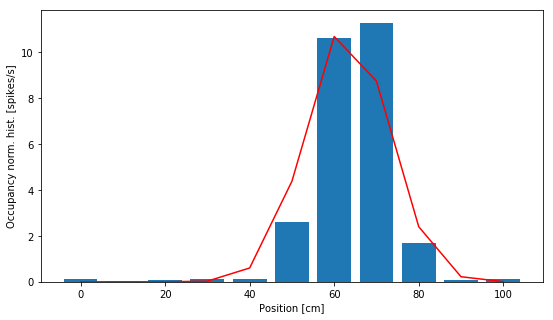

In [13]:
plt.bar(bins, spikehist/occupancy, width=8)    # Plot results as bars.
plot(bins,np.exp(b3[0]+b3[1]*bins + b3[2]*bins**2)*1000,'r')   # Plot model.
plt.xlabel('Position [cm]')                    # Label the axes.
plt.ylabel('Occupancy norm. hist. [spikes/s]')
plt.show()

We see from the figure above that model 3 aligns much more closely with the occupancy normalized histogram. The firing rate is small at the beginning of the track, increases to a maximum firing rate near 10 Hz about 60 cm along the track, and then decreases as the position increases further. The firing rate model as a function of position looks like the bell-shaped or mound-shaped density that we often associate with the Gaussian (or normal) distribution. The fact that the firing rate is the exponential of a quadratic function of position means that we can rewrite the model in a form that more closely resembles the Gaussian function:

$$ \lambda(t) = \alpha \exp\left(-\frac{(x - \mu)^2}{ 2\sigma^2}\right),$$

where $\mu = −\beta_1/(2\beta_2)$ is the point along the track where the firing rate is maximal (the center of the place field), $\sigma_2 = −1/(2\beta_2)$ determines the range over which the firing rate is elevated (the size of the place field), and $\alpha = \exp(\beta_0−\beta_1^2/(4\beta_2))$ is the maximum firing rate at the place field center.

In this example, we can use the estimated GLM coefficients to estimate these new model parameters related to the center, size, and maximum firing rate of the place field. The fit method has given us the maximum likelihood estimates for $\beta_0$, $\beta_1$, and $\beta_2$. An important result from statistical theory is that the maximum likelihood estimate of any function of model parameters is just that same function of the maximum likelihood estimates of the parameters. This is often called invariance or equivariance [6]. So $\hat{\mu} = −\hat\beta_1/(2\hat{\beta_2})$ is the maximum likelihood estimate of the place field center, $\hat{\sigma} = \sqrt{-1/(2\hat{\beta_2})}$ is the maximum likelihood estimate of the place field size, and so on.

Let’s now use these expressions to compute the maximum likelihood estimates in Python:

In [14]:
#Compute maximum likelihood estimates of
mu = -b3[1]/(2*b3[2])                   # place field center
sigma = np.sqrt(-1/(2*b3[2]))           # place field size
alpha = np.exp(b3[0]-b3[1]**2/4/b3[2])  # max firing rate

Executing these lines of code we find `mu = 63.16295780404517`, `sigma = 9.566890841873276`, and `alpha = 0.011285495199183409`.

<div class="alert alert-block alert-info">
**Q:** What are the units of each of these parameter estimates?<br><br>

**A:** The units for mu and sigma are centimeters, the same as the units of X. The units for alpha, the maximum spike rate, are spikes per time step of the vector spiketrain. Since each time step is 1 ms, the units are spikes/ms. So a value of $\hat{\alpha} = 0.011$ spikes/ms is equivalent to a maximum firing rate of $\hat{\alpha} = 11$ spikes/s.

We see that the estimated place field center is about 63.2 cm down the track. The estimated place field size, $\hat{\sigma} = 9.6$, suggests that the firing rate decreases about 40% when the rat is about 9.6 cm from the place field center, and decreases about 85% when the rat is about 19 cm from the place field center. The neuron spikes at a rate near $\hat{\alpha}= 11$ spikes/s when the rat is 63 cm along the track, but less than 2 spikes/s when the rat is more than 19 cm away from that position.

### Comparing and Evaluating Models

We have fit a number of models for the receptive field of this neuron and compared these models through visual inspection. Ideally, we’d like to go beyond qualitative comparisons and consider quantitative tools to help us evaluate and compare different models. For statistical models, we often use the term *goodness-of-fit* to describe how well a model captures structure in the observed data, and how well the model predicts future data. There is not a single procedure for measuring goodness-of-fit; instead there are many tools that, taken together, can provide a broad perspective on the strengths and weaknesses of a set of models. We explore some approaches for comparing the relative goodness-of-fit between two models and then methods to assess the overall goodness-of-fit of a single model.

#### Method 1: Comparing AIC Values. 

Let’s say we want to compare the quality of the fit to the data of models 2 and 3. What measure could we use to compare these models? A natural thought is to use the likelihood. We have already used the likelihood to select the parameter values for each of these models; we selected the parameters that maximized the likelihood of the data. We can think of selecting the model parameters as selecting among a set of models with the same model form but different parameter values. In that case, the likelihood was the measure we used to make the selection.

However, there is a major issue with using the likelihood alone to compare goodness-of-fit between different classes of models. It turns out that as we add parameters to the model and make the model more complex, we tend to increase the likelihood of the data, whether or not those additional terms accurately describe the processes that generate the data. If we were to select models that maximize the likelihood of the data without regard for model size, we would tend to get very large models that fit the observed data well but do not predict or describe future data well. This is known as the *overfitting problem*. In order to avoid overfitting, we are compelled to balance the ability to fit complicated datasets with the desire to use simple models with small numbers of parameters. This trade-off is sometimes referred to as the goal of *parsimony* in modeling. We want to be sparing with the number of parameters we allow a model to have. We call a model that describes the data well with the fewest possible parameters a *parsimonious model*.

One common approach for preventing overfitting is *cross-validation*. There are multiple types of cross-validation, but they all share a common idea: split the data into multiple portions, fit the model on one portion of the data (called the training set), and determine how well the resulting model fit describes a separate portion of the data (called the test set). This ensures that the selected model is one that can generalize to additional datasets that were not used to fit the model. One challenge with cross-validation is that it can be computationally expensive. For example, one of the most robust cross-validation approaches, called complete leave-one-out cross-validation, involves sequentially leaving out each data point, fitting a model to the remaining data, and assessing how well the fitted model predicts the excluded data point. This involves fitting $n$ models, where $n$ is the number of data points observed.

Here, instead of fitting a large number of models, we take another approach, which gives results equivalent to cross-validation when the dataset is large. Namely, we use penalized likelihood measures to compare model types. These measures make explicit the trade-off between fitting the data well (by increasing the likelihood) and using a small number of parameters (by penalizing large models). Let’s consider one such measure, *Akaike’s information criterion* (AIC). It is defined as,

$$\text{AIC} = −2 \log L(\theta_{ML}) + 2p,$$

where $L(\theta_{ML})$ is the likelihood of the data for the selected maximum likelihood parameter estimate $
\theta_{ML}$, and $p$ is the number of parameters in the model. We think of the $2p$ in expression as a penalty for models with large numbers of parameters.

When comparing models, we compute the AIC for each model separately, and then compute the difference in AICs between models. For models that accurately describe the structure of the data, $L(\theta_{ML})$  will be high, and therefore $−2\log L(\theta_{ML})$  will be small. Parsimonious models will have small numbers of parameters, and therefore $2p$ will be small. Therefore, we are looking for models with AIC values as small as possible.

How do we compute the likelihood or log likelihood of the data for the models in Python? One way is to use the fact that we are modeling the spike train as a Poisson random variable at each time point with rate parameters determined by the model. For model 2, we can compute the AIC as follows:

In [15]:
LL2 = model2.loglike(b2)
AIC2 = -2*LL2+2*2

The first line of this code computes the log likelihood for model 2. Recall that the likelihood is the joint distribution of all the data for a specific model. In this case, the number of spikes in each bin is modeled as a Poisson random variable with rate $\lambda(t)$. Therefore, the log likelihood (`LL2`) is just the logarithm of the product of Poisson probability values for the observed spiking under the proposed model (or equivalently, the sum of the log of these Poisson probability values). The third line computes the AIC for this model. Notice that in the last line we use a value of p = 2, as there are two parameters in this model ($\beta_0$ and $\beta_1$).

Similarly, we can compute the AIC for model 3:

In [16]:
LL3 = model3.loglike(b3)
AIC3 = -2*LL3+2*3

<div class="alert alert-block alert-info">
**Q:** Consider the definition of AIC3. Can you explain in words the different terms? What does the term 2*3 represent? How many parameters are there in model 3?
</div>

Finally, we can compute the difference between the AIC values for these two models:

In [17]:
dAIC=AIC2-AIC3

We find a value of `dAIC = 636.0145`. This difference indicates that the AIC of model 3 is smaller than that of model 2, suggesting that model 3 is superior. How should we interpret the value of the difference? The answer depends on the probability model we are using, and generally we are just interested in which model has the lowest AIC without worrying about the magnitude of the difference. However, one rough way of thinking about this value is in terms of the penalty. The fact that model 3 has an AIC of about 636 less than the AIC of model 2 suggests that model 3 would still be preferable to model 2 even if model 3 had 636/2 = 318 more parameters than it actually does.

It turns out that there is a simpler way to compute the difference in AICs between two GLMs. Whenever Python (and most other computational software packages) computes the maximum likelihood solution for a GLM, it also computes the model deviance. The model deviance is a measure of lack of fit between the model and data, which is defined by
$$\text{Deviance }= −2\log L(\theta_{ML}) + C, $$

where C is a constant <sup>1</sup>. Therefore the difference in AICs between two models can be computed as

$$\Delta \text{AIC}=\text{AIC}_1−\text{AIC}_2 = \text{Dev}_1+2p_1 − \text{Dev}_2+2p_2,$$

where $\text{AIC}_1$, $\text{Dev}_1$, and $p_1$ are the AIC, deviance, and number of parameters for the first model, and $\text{AIC}_2$, $\text{Dev}_2$, and $p_2$ are the AIC, deviance, and number of parameters for the second model. The constant $C$ cancels out when computing the difference in AIC values.

In Python, we can compute the values for the deviance and the AIC difference as follows:

<a name="myfootnote1">1</a>: 
 The constant C is equal to −2 times the log likelihood of a saturated model that has as many parameters as points in the data. Such a model is guaranteed to overfit the data, namely, it will fit the observed data as well as possible but not generalize well to new data.

In [18]:
dev2 = model2_results.deviance # Deviance from model 2
dev3 = model3_results.deviance # Deviance from model 3
dAIC=(dev2+2*2)-(dev3+2*3)

The resulting difference in AICs (variable dAIC) matches the value we computed earlier.

#### Method 2: Chi-Square Test for Nested Models. 

The AIC provides a method for identifying parsimonious models and comparing between models but does not, on its own, indicate whether a particular model provides a statistically significant improvement in its description of a dataset. For example, we might add a predictor to a model that has no real connection to the observed data and yet decreases the AIC by chance. In order to assess whether a model provides a significant improvement over another, we can use hypothesis tests based on the model likelihoods.

In particular, there is a general class of hypothesis tests called *maximum likelihood ratio tests* (MLRTs) that often provide the most statistically powerful comparison between models. In general, it can be challenging to compute the test statistic and its sampling distribution for MLRTs. However, it becomes easy to perform this test in cases where we are comparing two nested GLMs, that is, when one of the models can be made equivalent to the other by setting some parameters to specific values. For example, it is possible to make model 3 equivalent to model 2 by setting $\beta_2 = 0$. We say that model 2 is nested in model 3. However, there is no way to set any parameters to make model 2 equivalent to model 1 or vice versa, so these models are not nested. It can be shown that when we compare two nested Poisson GLMs for spike train data, the MLRT will asymptotically be a simple chi-square ($\chi^2$) test. The proof for this result can be found in many textbooks on GLMs, such as [29].

Let’s specify the components of this hypothesis test. Assume that the nested model has $n1$ parameters $\{\beta_1, \cdots, \beta_{n_2} \}$, and that the larger model has $n_2$ parameters, $\{\tilde{\beta_1}, \cdots, \tilde{\beta_{n_2}} \}$. The null hypothesis for this test is $H_0 : \tilde{\beta_{n_1 + 1}} = \cdots = \tilde{\beta_{n_2}}= 0$, that all the additional parameters not contained in the nested model are equal to zero. The alternative hypothesis is that at least one of these additional parameters are different from zero. The test statistic for this MLRT is equivalent to the difference in the deviances between the nested model (here, $\text{Dev}_1$) and the larger model (here, $\text{Dev}_2$),

$$\Lambda = \text{Dev}_1 - \text{Dev}_2$$

Under the null hypothesis, this statistic should asymptotically have a chi-square distribution with $n_2 − n_1$ degrees of freedom. We can compute the p-value for a test comparing two nested GLMs for spiking data using chi2 in scipy.stats from Python.

Let’s compute the p-value for a MLRT comparing models 2 and 3:

In [19]:
from scipy.stats import chi2

p = 1 - chi2.cdf(dev2-dev3,1) # Compare Models 2 and 3, nested GLMs.

In this case, the difference in parameters between model 2 and model 3 is 1; model 3 has one additional parameter. We therefore set the degrees of freedom of the chi-square distribution to 1, the second input to the function `chi2.cdf`. We find the computed p-value is zero, to the precision that Python is able to compute the chi-square distribution. In practice, this means that the p-value for this test is not exactly zero but is smaller than 10−10. We have a great deal of evidence that the additional, quadratic parameter in model 3, $\beta_2$, is nonzero.

#### Method 3: Confidence Intervals for Individual Model Parameters. 

If we want to test directly for whether a single parameter contributes significantly to the model, we can examine its interval estimate. The GLM fitting procedure not only computes the maximum likelihood estimator for each model parameter but also computes the *Fisher information*, a quantity related to the curvature of the likelihood, which can be used to compute confidence intervals about any individual parameters or any combination of parameters. We do not discuss the Fisher information in detail here (for more, see [6]), but the basic idea is intuitive. If the likelihood is very flat at its maximum, then changing the parameter values slightly will not decrease the likelihood substantially. Therefore, there is a potentially large range of parameter values that could make the data likely. If the likelihood is very peaked at its maximum, then a slight change in the parameter values would cause a large change in the likelihood, and therefore a much narrower range of parameter values would be consistent with the data.

In the GLMResults class contains a variety of useful attributes. Two components that are useful for examining the significance of individual model parameters are `bse` and `pvalues`. The first, `bse`, provides the standard error of each parameter estimate. Since maximum likelihood estimators have approximately normal distributions with enough data, an approximate 95% confidence interval for any parameter $\beta_i$ would be $\beta_i \pm 2\hat{\sigma_{\beta_i}}$ , where $\beta_i$ is the parameter estimate and $\hat{\sigma_{\beta_i}}$ is the estimated standard error.

Let’s now use the `bse` attribute to compute confidence intervals for the parameters of model 2:

In [20]:
CI2 = np.array([b2-2*model2_results.bse, b2+2*model2_results.bse]) # Compute 95% CI for parameters of Model 2.

The left column of the variable `CI2` is the confidence interval for $\beta_0$, and the right column is the confidence interval for $\beta_1$. How should we interpret these confidence intervals? Just as before, they will be more interpretable if we exponentiate first.

In [21]:
eCI2 = np.exp(CI2)

The confidence interval for $\beta_0$ describes the uncertainty in the firing rate at position x = 0. At that position, we are 95% certain that the rate is between 0.0004 and 0.0008 (the left column of `eCI2`) spikes per millisecond, or between 0.4 and 0.8 spikes per second. The confidence interval for $\beta_1$ describes the uncertainty in the effect of a unit change in position on the firing rate. Every time we increase $x$ by 1, the rate gets modulated by a value between 1.009 and 1.0171 (the second column of `eCI2`). In other words, each centimeter increase in position increases the firing rate between about 0.9% and 1.7%.

Another use for the confidence intervals is to express the statistical significance of individual parameters within the model. If the true value of a parameter is zero, then the covariate corresponding to that parameter does not contribute to the prediction of the data in the GLM. If we compute a confidence interval for a parameter and it does not contain zero, we have sufficient evidence (at the confidence level used to construct the interval) that the true parameter value differs from zero, and that the covariate for that parameter has a significant contribution within the GLM. We can use this once again to determine whether the addition of the quadratic term in model 3 provides a significant improvement over model 2. To do so, let’s use the computed output variables `b3` and `bse` for model 3 to determine the confidence intervals for each parameter in model 3.

In [22]:
CI3 = np.array([b3-2*model3_results.bse, b3+2*model3_results.bse]) # Compute 95% CI for parameters of Model 3.

The resulting variable `CI3` consists of three columns. The rightmost column is the confidence interval for $\beta_2$. We see that this interval (`CI3[:,2]=[-0.0063 -0.0046]`) does not contain zero, so the quadratic term is significant at the 95% confidence level.

How significant is this term? To answer this, we can conduct a hypothesis test for whether $\beta_2$ is different from zero. This test, based on the maximum likelihood estimate of a model parameter and its standard error, is called a *Wald test*. The significance level of this test is given by the `pvalues` attribute of the `GLMResult` class. For model 3, the significance level for parameter $\beta_2$ is

In [23]:
p_beta2 = model3_results.pvalues[2]

We find `p_beta2 = 4.12e-38`, which is very close to zero. This result is consistent with our previous finding, via the MLRT, that the improvement of model 3 over model 2 suggested that the quadratic model component was significant at a level of $p < 10^{−10}$.

#### Method 4: KS Test for Model Goodness-of-Fit. 

The goodness-of-fit methods we have developed so far are useful for comparing models and for determining whether individual variables contribute significantly to a model. However, these methods do not tell us whether the model captures the structure of the spiking data well overall. There are a number of methods to evaluate the overall goodness-of-fit between a model and data, but here we focus on an approach specific to point process (spike) data. The method is based on an important result known as the *time-rescaling theorem*.

In many statistical analyses, we assume that the data are identically distributed, that is, that all the data come from the same probability model and have the same mean. A common goodness-of-fit method is then to compare the empirical distribution of the data to that single probability model. However, for most spike trains, the data are not identically distributed. For example, the rate of spiking may change as a function of time or with other covariates, so the expected interspike interval changes for each data point. The time-rescaling theorem provides a transformation of the data that is identically distributed if the rate model is correct.

We first state the time-rescaling theorem for Poisson processes.2

---
#### Time-Rescaling Theorem:

Consider a collection of spike times $(S_1 , S_2 , \cdots, S_n)$ from a Poisson process with rate function $\lambda(t)$. Then let

$$Z_1 = \int_0^{S_1} \lambda(t)dt \quad \text{ and } \quad Z_i = \int_{S_{i-1}}^{S_i} \lambda(t) dt,$$

for $i = 2, \cdots, n$. By the time-rescaling theorem, the rescaled variables, $Z_1 , Z_2 ,\cdots , Z_n,$ are independent and identically distributed random variables from the exponential distribution with parameter 1.
<hr>

We do not prove the time-rescaling theorem here but note that it comes from the change-of-variables formula from basic probability theory; see [6] for a detailed proof.

How do we use the time-rescaling theorem to analyze spike train data? If we have a collection of spike times, $S_1 , S_2 , \cdots , S_n$, and any Poisson rate model, say, from a fit GLM, then we can compute the rescaled waiting times, $Z_1,Z_2,\cdots ,Z_n$. We then perform any standard goodness-of-fit method to compare $Z_1,Z_2,\cdots ,Z_n$ to the exponential probability model. If the Poisson rate model describes the data well, then the exponential model should describe the rescaled times well.

The actual goodness-of-fit technique we use for the rescaled data is the *Kolmogorov-Smirnov (KS) plot*. Recall from chapter 8 that the KS plot compares the empirical cumulative distribution function (CDF) of the data to a model CDF. In that chapter, we compared the empirical CDF for observed interspike intervals against various model CDFs. In this case, we compare the empirical CDF of the rescaled waiting times to an exponential CDF.

Let’s now apply the time-rescaling theorem to evaluate model 3. First we must compute the rescaled waiting times. In Python,

In [24]:
N = len(spiketimes)                                  # Define no. of of spikes.
lambda3 = np.exp( b3[0] + b3[1]*X +b3[2]*X**2)       # Evaluate Model 3.

Z = sum(lambda3[0:spikeindex[0]])                    # 1st rescaled waiting time,
for i in range(N-1):
    Zi = sum(lambda3[spikeindex[i]:spikeindex[i+1]]) # Compute ith rescaled waiting time
    Z = np.concatenate((Z, Zi))                      # Add to previous array of rescaled waiting times.

<div class="alert alert-block alert-info">
**Q:** Do you understand how the variable `Z` approximates the integral of the model?
</div>

Next, we compute the empirical CDF of these rescaled waiting times using the MATLAB function ecdf:

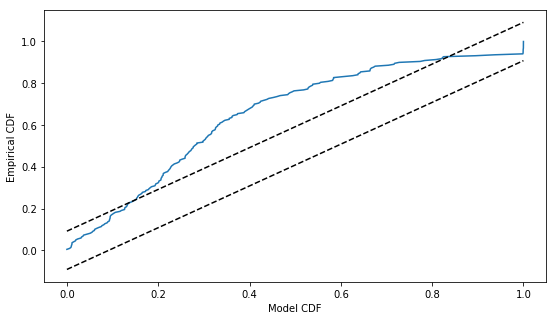

In [25]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(Z)
mCDF = 1 - np.exp(-ecdf.x)
plt.figure()
plot(mCDF, ecdf.y)
plot([0,1], [0,1] + 1.36/np.sqrt(N),'k--', ms = 2)
plot([0,1], [0,1] - 1.36/np.sqrt(N),'k--', ms = 2)
plt.xlabel('Model CDF')                 #Label the axes.
plt.ylabel('Empirical CDF')
show()

<div class="alert alert-info alert-block">
**Q:** Does the definition of the model CDF (variable `mCDF`) make sense? Remember that by the time-rescaling theorem, we expect that the rescaled variables $(Z_1,Z_2,\cdots,Z_n)$ are from the exponential distribution with parameter 1.
</div>

<div class="alert alert-info alert-block">
**Q:** Consider the KS plot above. By the time-rescaling theorem, is model 3 an adequate model of the data? <br><br>

**A:** If the spiking data came from a Poisson process with a rate given by model 3, then we would expect the KS plot to remain within the 95% confidence bounds, or any departures from these bounds to be small. We find that the KS plot takes on values far outside of the 95% confidence bounds. Therefore, we conclude that our model is not completely capturing the structure of the spiking data.
</div>

#### Method 5: Residual Analysis. 

Residuals represent the difference between the data and the model prediction at the level of individual data points. While quantities such as the deviance or KS plot are useful for getting an overall picture of how well the model fits the data as a whole, residual analysis is essential for understanding which components of a dataset are well or ill fit by the model. It is therefore one of the best tools for determining what is missing in a model.

There are many types of residuals that can be computed for point process data (including raw residuals, Pearson residuals, and deviance residuals [29]). We do not go into detail about the advantages of each type of residual. Instead, let’s focus on one type of residual that is particularly useful for spiking data: the cumulative raw residual process. In continuous time, we would compute this residual process, $R(t)$, as

$$\begin{align}
R(t) &= \text{ total observed no. of spikes at time } t - \text{ total expected no. of spikes at time } t \\
     &= N(t) - \int_0^t\lambda(u)du,
     \end{align}$$
where $N(t)$ is the counting process that gives the total number of spikes fired up to time $t$, and $\lambda(t)$ is the Poisson rate model at time $t$. The residual process $R(t)$ compares what’s observed (i.e., the spikes recorded in the data) to what the model produces. Since we are working in discrete time, at any time point $t_k$ we compute this as
$$ R(t_k) = \sum_{i=1}^k \Delta N_i  - \lambda(t_i)\Delta t,$$
where $\Delta N_i$ is the number of spikes that are observed in the discrete-time interval $t_i$.

In Python, we compute $R(t_k)$ by taking the cumulative sum of the raw residuals, which are returned as an attribute of the GLMResults class. Then, to compute the cumulative sum of these residuals, we use the function `np.cumsum` as follows:

In [26]:
R = np.cumsum(model3_results.resid_response)

To inspect how the cumulative residual process evolves in time, let’s plot it:

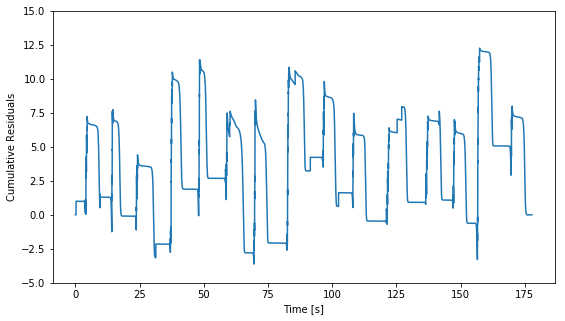

In [27]:
plot(t,R)
plt.ylim(-5, 15)
plt.xlabel('Time [s]')
plt.ylabel('Cumulative Residuals')
show()

If model 3 were correct, then the residuals should be zero mean and uncorrelated with any covariates. We see in the figure above that the cumulative residual process ends at zero, suggesting that the residuals sum to zero over all time steps. However, we also identify a pattern in the residual process, which suggests that there is still some structure in the data that is not captured by model 3. More specifically, visual inspection suggests a relation between the residuals and a model covariate: the position (plotted below). We observe that the cumulative residual process seems to increase whenever the rat in moving in the positive direction and to decrease whenever the rat is moving in the negative direction. This analysis suggests exactly what has been missing from our models: direction.

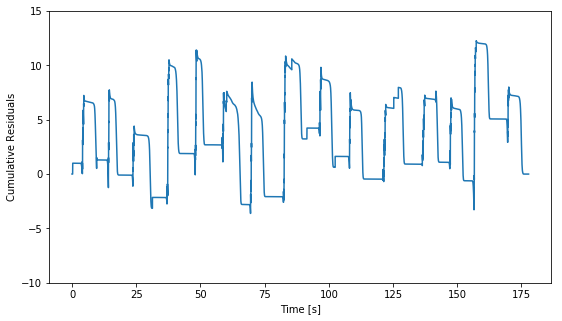

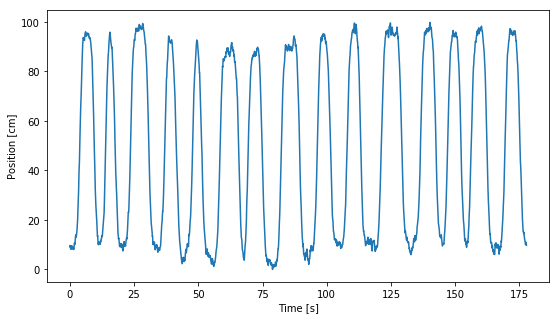

In [28]:
# Comparison of Cumulative residuals over time and rat position over time.
plot(t,R)
plt.ylim(-10, 15)
plt.xlabel('Time [s]')
plt.ylabel('Cumulative Residuals')
show()
plot(t,X)
plt.xlabel('Time [s]')
plt.ylabel('Position [cm]')
show()

### 9.2.5 Refining the Model (Continued)

Our goodness-of-fit analysis suggested that model 3 provided a significant improvement over model 2. However, analysis of the cumulative residual process revealed that model 3 misses an essential feature of the data: model 3 does not account for the dependence of spiking on direction. So, let’s refine the model by including a new covariate that captures the direction of the rat’s movement.

We must first define a simple indicator function for the direction of movement. If the value of $X(t)$ increased since the last time step, we set this variable to 1; otherwise we set it to 0. For the very first time step, we don’t know from which direction the rat came, so we set it to 0 arbitrarily. In Python,

In [29]:
diff = np.diff(X.flatten())>0                        # Array for if X(t) increased since last step
direction = np.array([1 if d else 0 for d in diff])  # Convert to ones and zeros
direction = np.concatenate(([0], direction))         # Set first step to 0.

<div class="alert alert-block alert-info">
**Q:** Does the variable `direction` indicate the direction of movement with a 0 or 1, as we desire? Hint: Consider the Python function diff and how this function is used to find times when $X(t)$ increases.
</div>

With the indicator function for the direction of movement now defined, we must incorporate this new signal into the model. The simplest solution is to add the `direction` variable directly as a new predictor. This would lead to a new model,

$$ \lambda(t) = \exp( \beta_0+ \beta_1 x(t)+ \beta_2 x(t)^2+ \beta_3 \text{direction}).$$

We then fit this model and interpret the parameter estimates. With our previous experience in this chapter, fitting the model in Python is now relatively straightforward:

In [30]:
#Fit Model 4, and return estimates and useful statistics.
X3 = np.hstack([X2, np.reshape(direction, (-1, 1))]) #Add column for x(t)^2
model4 = sm.GLM(spiketrain, X3, family=Poisson()) # GLM model with Poisson family and identity link function
model4_results = model4.fit() # Fit model to our data
b4 = model4_results.params # Get the predicted coefficient vector

<div class="alert alert-info alert-block">
**Q:** Do you see how, in this code, the three covariates (position, position squared, and direction) are included as inputs to the GLM model?
</div>

We are particularly interested in the final parameter estimate. When the direction indicator variable is equal to zero—when the rat is moving in the negative direction or standing still—this component does not affect the rate. When the direction indicator is 1, this component of the model modulates the rate by $e^{\beta_3}$. For our estimated parameter we find `b4[3] = 3.2753` and therefore that $e^{\beta_3}= 26.4521$.

<div class="alert alert-info alert-block">
**Q:** What is the impact of direction on the firing rate?<br><br>

**A:** Under this model, when the rat is moving in the positive direction, the firing rate is more than 26 times higher than the firing rate when the animal is moving in the negative direction. Since we only observe the rat long enough for the place cell to fire a few hundred spikes, we expect the majority of these spikes to occur when the animal is moving in the positive direction.
</div>

We could perform the same change of parameters for this model as for the alternative form of model 3. We previously expressed model 3 using a mean, width, and maximum firing rate for the place field. If we performed this change of parameters for model 4, we would still have just a single mean, width, and maximum rate parameter, and one additional parameter related to the modulation of direction, whose estimated value would not change.

### 9.2.6 Comparing and Evaluating Models (Continued)

Now that we have a new model that attempts to capture the dependence of spiking on movement direction, let’s compare the resulting model fit to the previous model fits and evaluate the overall goodness-of-fit of this new model. First, we compare the AIC values between models 3 and 4:

In [31]:
dev4 = model4_results.deviance # Deviance from model 2
dAIC=(dev3+2*3)-(dev4+2*4) #Difference in AIC between Models 3&4.

<div class="alert alert-info alert-block">
**Q:** Why do we use the terms 2*3 for model 3 and 2*4 for model 4?
</div>

We find `dAIC = 233.8806`, a difference that is positive and large, suggesting a significant improvement in the fit of model 4 compared to model 3. To evaluate the significance, we can once again perform an MLRT. Model 3 is clearly nested in model 4, since under the null hypothesis that  $\beta_3 = 0$, we obtain model 3. Because there is only one parameter to fix, the MLRT statistic would have a chi-square distribution with 1 degree of freedom if the null hypothesis were true. So we compute the p-value for this test as

In [32]:
p = 1 - chi2.cdf(dev3 - dev4, 1)# Compare Models 3 and 4, nested GLMs.

and find $p = 0$. Again, we see that the addition of a parameter leads to a highly significant improvement in the fit to the data.

Next, let’s compute the confidence interval and significance for the $\beta_3$ parameter:

In [33]:
# For Model 4, compute 95% CI for last parameter,
CI_beta3 = [b4[3] - 2*model4_results.bse[3], b4[3] + 2*model4_results.bse[3]]
p_beta3 = model4_results.pvalues[3] # and significance level.

We find that the confidence interval (`CI_beta3 = [2.5550, 3.9957]`) does not contain the value zero, and is highly significantly different (`p_beta3 = 9.5422e-20`) from zero. These goodness-of-fit analyses corroborate each other in suggesting that including the direction term provides a significant improvement in capturing the observed spiking structure.

Next, we investigate the overall goodness-of-fit of this model using the time-rescaling theorem and by constructing a KS plot. In Python,

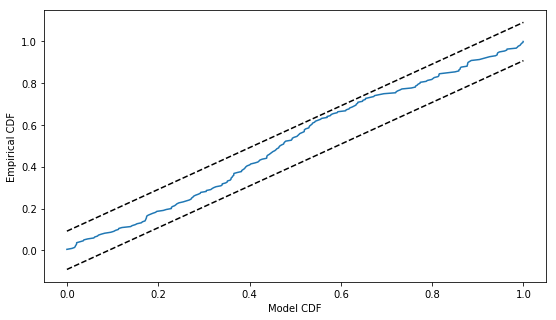

In [34]:
lambda4 = np.exp( b4[0] + b4[1]*X +b4[2]*X**2 + b4[3]*np.reshape(direction,(-1, 1)))

Z = sum(lambda4[0:spikeindex[0]])                    # 1st rescaled waiting time,
for i in range(N-1):
    Zi = sum(lambda4[spikeindex[i]:spikeindex[i+1]]) # Compute ith rescaled waiting time
    Z = np.concatenate((Z, Zi))                      # Add to previous array of rescaled waiting times.
    
ecdf = ECDF(Z)                                       # Define empirical cdf
mCDF = 1 - np.exp(-ecdf.x)                           # ... and model cdf
plt.figure()                                         # create KS plot 
plot(mCDF, ecdf.y)
plot([0,1], [0,1]+1.36/np.sqrt(N),'k--', ms = 2)       # Upper confidence bound
plot([0,1], [0,1]-1.36/np.sqrt(N),'k--', ms = 2)       # Lower confidence bound
plt.xlabel('Model CDF')                              # Label the axes.
plt.ylabel('Empirical CDF')
show()

The KS plot for model 4 looks much better than the one we constructed for model 3. We notice that the KS plot for model 4 stays within the 95% bounds everywhere, unlike the KS plot for model 3. This does not mean that the model is correct, but there is not significant evidence of lack-of-fit from the KS plot.

Finally let’s compute and examine the cumulative residual process:

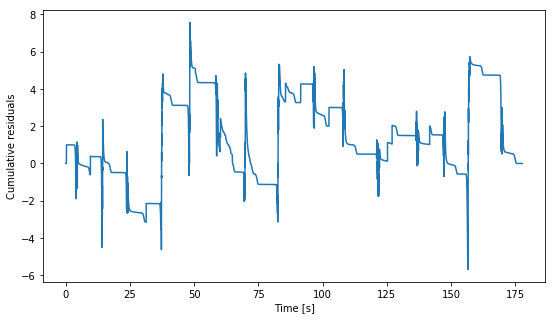

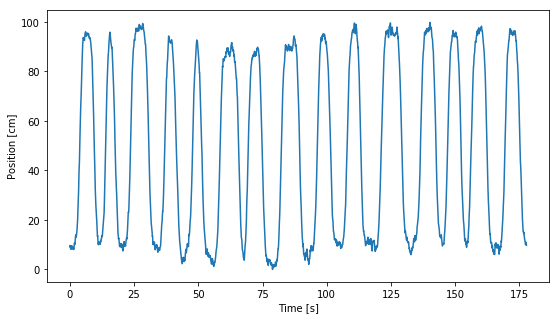

In [35]:
R = np.cumsum(model4_results.resid_response)  # Cumulative sum of Model 4 residuals.
plot(t,R)                            # Plot it.
plt.xlabel('Time [s]')
plt.ylabel('Cumulative residuals')
show()

plot(t, X)
plt.xlabel('Time [s]')
plt.ylabel('Position [cm]')
show()

The figure above plots the cumulative residual process for model 4 and the movement trajectory. We find that the residual process is now centered at zero. There may still be some structure as a function of time, but it is no longer as closely associated with the movement trajectory as for model 3.

### 9.2.7 Drawing Conclusions from the Model

It is likely that we could refine this model further, perhaps by adding additional covariates or including different dependence structure on the covariates we are currently using. The process of model refinement is not about identifying a single correct model. Instead, it is about building a model that sufficiently captures features of the data in which we are interested. For this analysis, let’s decide that based on our multiple goodness-of-fit tools, model 4 is good enough. We now use this model to better understand the structure of the place cell that generated these data.

The process of model refinement and comparison has helped us identify important features of this neuron’s receptive field. It was clear from the initial visualizations that this neuron’s firing activity is position sensitive; it is more likely to fire when the animal is at certain positions than others. Our modeling analysis further showed that this position dependence could be well described by an exponentiated quadratic function of position, that is, a Gaussian-shaped function.

Let’s now estimate parameters for the center, width, and maximum firing rate of this place field. To do so, we make use of the expressions derived for the alternative form of model 3. Computing these values for the estimates of model 4 (variable b4),

In [36]:
#For Model 4, compute maximum likelihood estimates of
mu = -b4[1]/ (2*b4[2])                    # place field center
sigma = np.sqrt(-1/(2*b4[2]))             # place field size
alpha = np.exp(b4[0] - b4[1]**2/(4*b4[2]))  # max firing rate

<div class="alert alert-info alert-block">
**Q:** Interpret the values you computed. What do you find?<br><br>

**A:** The place field is centered approximately 63 cm down the track (`mu = 63.18`), and most of the firing activity occurs in a region between about $63\pm 19$ cm (`sigma = 9.58`, so `2 * sigma = 19.16`). At first, the maximum firing rate value of about `alpha = 8.2e-4` spikes/ms, or 0.8 spikes/s seems too small, until we realize that this is the maximum firing rate only when `dir=0`. When `dir=1`, this is multiplied by $e^{\beta_3}=$ `exp(b4[3])=26.451`. The maximum firing rate when the rat moves in the positive direction is about 22 spikes/s.
</div>

Let’s also visualize the firing rate as a function of both position and direction. We use the `predict` function to do this. This function uses both the parameter estimates and the stats structure that is output by `fit`, and computes the estimated Poisson rate function.

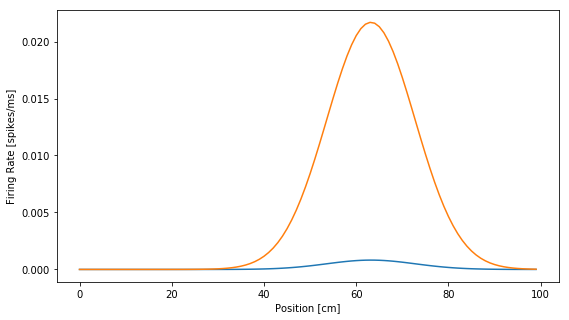

In [50]:
xs=np.arange(0, 100)
N=len(xs)
dir_0 = np.array([np.ones(N), xs, xs**2, np.zeros(N)]).T
dir_1 = np.array([np.ones(N), xs, xs**2, np.ones(N)]).T
lambda4_0 = model4_results.predict(dir_0)
lambda4_1 = model4_results.predict(dir_1)
plt.figure()
plot(xs, lambda4_0)
plot(xs, lambda4_1)
plt.xlabel('Position [cm]')
plt.ylabel('Firing Rate [spikes/ms]')
plt.show()

<div class="alert alert-info alert-block">
    **Q:** Consider the inputs to the function `predict` in this code. How are the covariates of position, position squared, and direction defined? What distinguishes model 4 evaluated for increasing position versus decreasing position?
</div>

<div class="alert alert-info alert-block">
**Q:** Consider the estimated Poisson rate function versus the covariate of position for model 4 plotted in the above figure. How does the firing rate vary with position and direction? <br><br>

**A:** Inspection of the figure reveals that the firing rate depends on both position and direction. The rate is largest near position 63 cm and when the position is increasing. When the position is decreasing, the increase in rate near position 63 cm is much smaller. These model 4 results, evaluated using parameters fitted to the observed data are consistent with our initial visualizations of the data.
</div>

We can also draw some conclusions about the data from elements not in the fitted model. As we discuss in chapter 10, the defining feature of Poisson models is that they have no history-dependent structure; the probability of a spike at any moment can depend on a variety of factors, but it does not depend on past spiking. The fact that we were able to achieve a good fit (based on the KS plot analysis) from a Poisson model suggests that past spiking dependence is not required to capture much of the essential statistical structure in the data. Similarly, other covariates, such as movement speed, were not required to capture the place field structure of this neuron. The neuron may still code for these variables; however we can describe the spiking structure in terms of other variables.

## Summary

In this case study, we used an iterative process to identify a statistical model for a hipocampal place cell. We started by visualizing the data, and then proposed point process models, compared and evaluated those models, refined the models, and finally drew inferences from a model that sufficiently captured the structure in the data that we were trying to explain. Each step of this procedure should inform the next. The goal of the visualization analysis is to identify covariates and receptive field structure to include in the first proposed models. The goodness-of-fit analysis should provide insight into features of the statistical model that are lacking and suggest new models. In this case study, we settled on a good model after just two iterations of model refinement. In practice, it may take many more iterations—or even iterations between model identification and new experiments—to identify good models.


It is worth noting that more than half of this case study is devoted to model interpretation and goodness-of-fit methods. This is common for advanced statistical analyses; fitting models to data is often the easy part. The challenge often comes in being able to interpret and evaluate the results of the fitting procedure. Since there is not a single correct way to evaluate a model, we instead use a range of tools to evaluate multiple aspects of model quality. Here we focused on a few that are generally useful for point process data and for Poisson modeling in particular. In the next chapter, we look at additional goodness-of-fit methods, in particular, ones to get at history dependence and rhythmicity in spiking data.